In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import mstats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

C:\Users\Gebruiker\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_excel('Final dataset for real3.xlsx', index_col = 0)
data = data.reset_index()

In [3]:
data.count()

Company name           21233
Country ISO code       21233
Nr. of Tax Treaties    21233
NACE Rev. 2            21170
Operating revenue      19609
Number of employees    13013
PBT                    21233
Total assets           21224
ROA                    19716
No of subsidiaries     21233
Solvency ratio         20407
Long term debt         18793
Debtors                21121
Current liabilities    21132
Size                   21233
Accounting practice    21233
Degree                 18639
Closeness              18639
Betweenness            18639
Eigenvector            18639
Hubs                   18639
ETR                    21233
dtype: int64

In [4]:
data['Country ISO code'] = data['Country ISO code'].astype('category')
data['Size'] = data['Size'].astype('category')
data['Accounting practice'] = data['Accounting practice'].astype('category')
data['NACE Rev. 2'] = data['NACE Rev. 2'].astype('category')

X = data[["Nr. of Tax Treaties","NACE Rev. 2","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities", "Size","Accounting practice","Degree","Closeness","Betweenness","Eigenvector","Hubs"]]
y = data["ETR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 2031996, shuffle = True)

X_train_con = X_train[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_train_cat = X_train[['NACE Rev. 2', 'Size', 'Accounting practice']]

scaler = StandardScaler()
scaler.fit(X_train_con)
StandardScaler()
X_train_con = scaler.transform(X_train_con)

iim=IterativeImputer(#estimator=xgb.XGBRegressor(),
initial_strategy='median',
max_iter=10,
missing_values= np.nan,
random_state=2031996)

imputed_X_train_con = pd.DataFrame(iim.fit_transform(X_train_con), index = X_train.index)
imputed_X_train_con.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]

imputed_X_train_cat = pd.get_dummies(X_train_cat)
imputed_X_train = pd.concat([imputed_X_train_con, imputed_X_train_cat], axis = 1)

drop_na = pd.concat([imputed_X_train, y_train], axis = 1)
drop_na = drop_na.dropna()
drop_na = pd.DataFrame(drop_na)

X_train_final = drop_na.loc[:,:'Accounting practice_US GAAP']
y_train_final = drop_na['ETR']

X_test_con = X_test[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_test_cat = X_test[['NACE Rev. 2', 'Size', 'Accounting practice']]

X_test_con = scaler.transform(X_test_con)

imputed_X_test_con = pd.DataFrame(iim.transform(X_test_con), index = X_test.index)
imputed_X_test_con.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]

imputed_X_test_cat = pd.get_dummies(X_test_cat)
imputed_X_test = pd.concat([imputed_X_test_con, imputed_X_test_cat], axis = 1)

drop_na = pd.concat([imputed_X_test, y_test], axis = 1)
#drop_na = drop_na.dropna()
drop_na = pd.DataFrame(drop_na)

X_test_final = drop_na.loc[:,:'Accounting practice_US GAAP']
y_test_final = drop_na['ETR']

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)
print('Imputed' , X_train_final.shape, y_train_final.shape)

Train (16986, 19) (16986,)
Test (4247, 19) (4247,)
Imputed (16986, 29) (16986,)


In [5]:
def winsorize(dataframe, upper, lower, column_to_winsor):
    dataframe = dataframe.sort_values(column_to_winsor, ascending=False, ignore_index = True)
    amount = dataframe[column_to_winsor].count()
    up = int(amount * (upper/100))
    low = int(amount * (lower/100))
    data_winsor = dataframe.loc[low:up]
    return data_winsor

data_winsor = winsorize(data, 99,  1, 'ETR') 
data_winsor = winsorize(data_winsor, 99, 1, "Operating revenue")
data_winsor = winsorize(data_winsor, 99, 1, "Total assets")
data_winsor = winsorize(data_winsor, 99, 1, "Current liabilities")
data_winsor = winsorize(data_winsor, 99, 1, "Betweenness")
data_winsor = winsorize(data_winsor, 99, 1, "Long term debt")
data_winsor = winsorize(data_winsor, 99, 1, "PBT")

X_winsor = data_winsor[["Nr. of Tax Treaties","NACE Rev. 2","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities", "Size","Accounting practice","Degree","Closeness","Betweenness","Eigenvector","Hubs"]]
y_winsor = data_winsor["ETR"]

X_train_winsor, X_test_winsor, y_train_winsor, y_test_winsor = train_test_split(X_winsor, y_winsor, test_size=0.20, random_state= 2031996, shuffle = True)

X_train_con_winsor = X_train_winsor[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_train_cat_winsor = X_train_winsor[['NACE Rev. 2', 'Size', 'Accounting practice']]

scaler = StandardScaler()
scaler.fit(X_train_con_winsor)
StandardScaler()
X_train_con_winsor = scaler.transform(X_train_con_winsor)

iim=IterativeImputer(#estimator=xgb.XGBRegressor(),
initial_strategy='median',
max_iter=10,
missing_values= np.nan,
#skip_complete=True,
random_state=2031996)

imputed_X_train_con_winsor = pd.DataFrame(iim.fit_transform(X_train_con_winsor), index = X_train_winsor.index)
imputed_X_train_con_winsor.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]

#imputed_X_train = imputed_X_train.dropna()
imputed_X_train_cat_winsor = pd.get_dummies(X_train_cat_winsor)
imputed_X_train_winsor = pd.concat([imputed_X_train_con_winsor, imputed_X_train_cat_winsor], axis = 1)

drop_na_winsor = pd.concat([imputed_X_train_winsor, y_train_winsor], axis = 1)
drop_na_winsor = drop_na_winsor.dropna()
drop_na_winsor = pd.DataFrame(drop_na_winsor)

X_train_final_winsor = drop_na_winsor.loc[:,:'Accounting practice_US GAAP']
y_train_final_winsor = drop_na_winsor['ETR']

X_test_con_winsor = X_test_winsor[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_test_cat_winsor = X_test_winsor[['NACE Rev. 2', 'Size', 'Accounting practice']]

X_test_con_winsor = scaler.transform(X_test_con_winsor)

imputed_X_test_con_winsor = pd.DataFrame(iim.transform(X_test_con_winsor), index = X_test_winsor.index)
imputed_X_test_con_winsor.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]

imputed_X_test_cat_winsor = pd.get_dummies(X_test_cat_winsor)
imputed_X_test_winsor = pd.concat([imputed_X_test_con_winsor, imputed_X_test_cat_winsor], axis = 1)

drop_na_winsor = pd.concat([imputed_X_test_winsor, y_test_winsor], axis = 1)
#drop_na = drop_na.dropna()
drop_na_winsor = pd.DataFrame(drop_na_winsor)

X_test_final_winsor = drop_na_winsor.loc[:,:'Accounting practice_US GAAP']
y_test_final_winsor = drop_na_winsor['ETR']

print('Train', X_train_winsor.shape, y_train_winsor.shape)
print('Test', X_test_winsor.shape, y_test_winsor.shape)
print('Imputed train' , X_train_final_winsor.shape, y_train_final_winsor.shape)
print('Imputed test' , X_test_final_winsor.shape, y_test_final_winsor.shape)

Train (11108, 19) (11108,)
Test (2778, 19) (2778,)
Imputed train (11108, 29) (11108,)
Imputed test (2778, 29) (2778,)


In [26]:
def winsorize(dataframe, upper, lower, column_to_winsor):
    dataframe = dataframe.sort_values(column_to_winsor, ascending=False, ignore_index = True)
    amount = dataframe[column_to_winsor].count()
    up = int(amount * (upper/100))
    low = int(amount * (lower/100))
    data_winsor = dataframe.loc[low:up]
    return data_winsor

data_winsor2 = winsorize(data, 97.5,  4, 'ETR') 
data_winsor2 = winsorize(data_winsor2, 100,  4, "Operating revenue")
data_winsor2 = winsorize(data_winsor2, 100,  4, "Total assets")
data_winsor2 = winsorize(data_winsor2, 100,  4, "Current liabilities")
data_winsor2 = winsorize(data_winsor2, 100,  4, "Betweenness")
data_winsor2 = winsorize(data_winsor2, 100,  4, "Long term debt")
data_winsor2 = winsorize(data_winsor2, 97.5,  2.5, "PBT")

X_winsor2 = data_winsor2[["Nr. of Tax Treaties","NACE Rev. 2","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities", "Size","Accounting practice","Degree","Closeness","Betweenness","Eigenvector","Hubs"]]
y_winsor2 = data_winsor2["ETR"]

X_train_winsor2, X_test_winsor2, y_train_winsor2, y_test_winsor2 = train_test_split(X_winsor2, y_winsor2, test_size=0.20, random_state= 2031996, shuffle = True)

X_train_con_winsor2 = X_train_winsor2[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_train_cat_winsor2 = X_train_winsor2[['NACE Rev. 2', 'Size', 'Accounting practice']]

scaler = StandardScaler()
scaler.fit(X_train_con_winsor2)
StandardScaler()
X_train_con_winsor2 = scaler.transform(X_train_con_winsor2)

iim=IterativeImputer(#estimator=xgb.XGBRegressor(),
initial_strategy='median',
max_iter=10,
missing_values= np.nan,
#skip_complete=True,
random_state=2031996)

imputed_X_train_con_winsor2 = pd.DataFrame(iim.fit_transform(X_train_con_winsor2), index = X_train_winsor2.index)
imputed_X_train_con_winsor2.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]

#imputed_X_train = imputed_X_train.dropna()
imputed_X_train_cat_winsor2 = pd.get_dummies(X_train_cat_winsor2)
imputed_X_train_winsor2 = pd.concat([imputed_X_train_con_winsor2, imputed_X_train_cat_winsor2], axis = 1)

drop_na_winsor2 = pd.concat([imputed_X_train_winsor2, y_train_winsor2], axis = 1)
drop_na_winsor2 = drop_na_winsor2.dropna()
drop_na_winsor2 = pd.DataFrame(drop_na_winsor2)

X_train_final_winsor2 = drop_na_winsor2.loc[:,:'Accounting practice_US GAAP']
y_train_final_winsor2 = drop_na_winsor2['ETR']

X_test_con_winsor2 = X_test_winsor2[["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]]
X_test_cat_winsor2 = X_test_winsor2[['NACE Rev. 2', 'Size', 'Accounting practice']]

X_test_con_winsor2 = scaler.transform(X_test_con_winsor2)

imputed_X_test_con_winsor2 = pd.DataFrame(iim.transform(X_test_con_winsor2), index = X_test_winsor2.index)
imputed_X_test_con_winsor2.columns = ["Nr. of Tax Treaties","Operating revenue","Number of employees",
          "PBT","Total assets","ROA","No of subsidiaries","Solvency ratio","Long term debt","Debtors",
          "Current liabilities"]

imputed_X_test_cat_winsor2 = pd.get_dummies(X_test_cat_winsor2)
imputed_X_test_winsor2 = pd.concat([imputed_X_test_con_winsor2, imputed_X_test_cat_winsor2], axis = 1)

drop_na_winsor2 = pd.concat([imputed_X_test_winsor2, y_test_winsor2], axis = 1)
#drop_na = drop_na.dropna()
drop_na_winsor2 = pd.DataFrame(drop_na_winsor2)

X_test_final_winsor2 = drop_na_winsor2.loc[:,:'Accounting practice_US GAAP']
y_test_final_winsor2 = drop_na_winsor2['ETR']

print('Train', X_train_winsor2.shape, y_train_winsor2.shape)
print('Test', X_test_winsor2.shape, y_test_winsor2.shape)
print('Imputed train' , X_train_final_winsor2.shape, y_train_final_winsor2.shape)
print('Imputed test' , X_test_final_winsor2.shape, y_test_final_winsor2.shape)

Train (8877, 19) (8877,)
Test (2220, 19) (2220,)
Imputed train (8877, 29) (8877,)
Imputed test (2220, 29) (2220,)


In [7]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
min_samples_split = [2, 20, 50]
min_samples_leaf = [1, 20, 80]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [8]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train_final, y_train_final)
best_parameters = rf_random.best_estimator_
print(best_parameters)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestRegressor(max_depth=10, max_features='log2', min_samples_leaf=80,
                      n_estimators=650)


In [9]:
rf_winsor = RandomForestRegressor()
rf_random_winsor = RandomizedSearchCV(estimator = rf_winsor, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random_winsor.fit(X_train_final_winsor, y_train_final_winsor)
best_parameters_winsor = rf_random_winsor.best_estimator_
print(best_parameters_winsor)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestRegressor(bootstrap=False, max_depth=60, max_features='sqrt',
                      n_estimators=650)


In [10]:
rf_winsor2 = RandomForestRegressor()
rf_random_winsor2 = RandomizedSearchCV(estimator = rf_winsor2, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random_winsor2.fit(X_train_final_winsor2, y_train_final_winsor2)
best_parameters_winsor2 = rf_random_winsor2.best_estimator_
print(best_parameters_winsor2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestRegressor(bootstrap=False, max_depth=60, max_features='sqrt',
                      n_estimators=650)


In [11]:
n_estimators = [int(x) for x in np.linspace(start = 580, stop = 590, num = 5)]
max_features = ['log2']
max_depth = [int(x) for x in np.linspace(3, 6, num = 3)]
max_depth.append(None)
min_samples_split = [200, 250, 280]
min_samples_leaf = [590, 600, 610]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train_final, y_train_final)
best_parameters = rf_random.best_estimator_
print(best_parameters)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestRegressor(bootstrap=False, max_depth=6, max_features='log2',
                      min_samples_leaf=600, min_samples_split=200,
                      n_estimators=580)


In [13]:
n_estimators = [int(x) for x in np.linspace(start = 700, stop = 750, num = 5)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(70, 80, num = 5)]
max_depth.append(None)
min_samples_split = [190, 200, 210]
min_samples_leaf = [595, 600, 605]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_winsor = RandomForestRegressor()
rf_random_winsor = RandomizedSearchCV(estimator = rf_winsor, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random_winsor.fit(X_train_final_winsor, y_train_final_winsor)
best_parameters_winsor = rf_random_winsor.best_estimator_
print(best_parameters_winsor)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestRegressor(bootstrap=False, max_depth=77, max_features='sqrt',
                      min_samples_leaf=595, min_samples_split=210,
                      n_estimators=737)


In [14]:
n_estimators = [int(x) for x in np.linspace(start = 400, stop = 550, num = 15)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(1, 20, num = 15)]
max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(400, 550, num = 15)]
min_samples_leaf = [int(x) for x in np.linspace(300, 400, num = 15)]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_winsor2 = RandomForestRegressor()
rf_random_winsor2 = RandomizedSearchCV(estimator = rf_winsor2, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random_winsor2.fit(X_train_final_winsor2, y_train_final_winsor2)
best_parameters_winsor2 = rf_random_winsor2.best_estimator_
print(best_parameters_winsor2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestRegressor(bootstrap=False, max_depth=11, max_features='sqrt',
                      min_samples_leaf=342, min_samples_split=421,
                      n_estimators=464)


In [18]:
rf_for_pred = RandomForestRegressor(bootstrap=False, max_depth=3, max_features='log2',
                      min_samples_leaf=610, min_samples_split=280,
                      n_estimators=590)

rf_for_pred.fit(X_train_final,y_train_final)

y_pred = rf_for_pred.predict(X_test_final)

mae = mean_absolute_error(y_test_final, y_pred)
mse = mean_squared_error(y_test_final, y_pred)
rmse = np.sqrt(mse)
d_nonan = {'With outliers': [mse, rmse, mae]}
df_nonan = pd.DataFrame(d_nonan, index = ['MSE','RMSE','MAE'])
print(df_nonan)

      With outliers
MSE   132235.196388
RMSE     363.641577
MAE       67.482063


In [19]:
rf_for_pred_winsor = RandomForestRegressor(bootstrap=False, max_depth=60, max_features='sqrt',
                      n_estimators=650)

rf_for_pred_winsor.fit(X_train_final_winsor,y_train_final_winsor)

y_pred_winsor = rf_for_pred_winsor.predict(X_test_final_winsor)

mae_winsor = mean_absolute_error(y_test_final_winsor, y_pred_winsor)
mse_winsor = mean_squared_error(y_test_final_winsor, y_pred_winsor)
rmse_winsor = np.sqrt(mse_winsor)
d_nonan_winsor = {'1% outliers removed': [mse_winsor, rmse_winsor, mae_winsor]}
df_nonan_winsor = pd.DataFrame(d_nonan_winsor, index = ['MSE','RMSE','MAE'])
print(df_nonan_winsor)

      1% outliers removed
MSE            549.366232
RMSE            23.438563
MAE             12.506354


In [20]:
rf_for_pred_winsor2 = RandomForestRegressor(bootstrap=False, max_depth=60, max_features='sqrt',
                      n_estimators=650)

rf_for_pred_winsor2.fit(X_train_final_winsor2,y_train_final_winsor2)

y_pred_winsor2 = rf_for_pred_winsor2.predict(X_test_final_winsor2)

mae_winsor2 = mean_absolute_error(y_test_final_winsor2, y_pred_winsor2)
mse_winsor2 = mean_squared_error(y_test_final_winsor2, y_pred_winsor2)
rmse_winsor2 = np.sqrt(mse_winsor2)
d_nonan_winsor2 = {'5% outliers removed': [mse_winsor2, rmse_winsor2, mae_winsor2]}
df_nonan_winsor2 = pd.DataFrame(d_nonan_winsor2, index = ['MSE','RMSE','MAE'])
print(df_nonan_winsor2)

      5% outliers removed
MSE            174.156017
RMSE            13.196818
MAE              8.716184


In [28]:
rf_for_pred = RandomForestRegressor(max_depth=110, max_features='log2', min_samples_leaf=80,
                      min_samples_split=50, n_estimators=200)

rf_for_pred.fit(X_train_final,y_train_final)

y_pred = rf_for_pred.predict(X_test_final)

mae = mean_absolute_error(y_test_final, y_pred)
mse = mean_squared_error(y_test_final, y_pred)
rmse = np.sqrt(mse)
d_nonan = {'With outliers': [mse, rmse, mae]}
df_nonan = pd.DataFrame(d_nonan, index = ['MSE','RMSE','MAE'])
print(df_nonan)

      With outliers
MSE   135304.965128
RMSE     367.838232
MAE       71.039940


In [29]:
rf_for_pred_winsor = RandomForestRegressor(n_estimators=1100)

rf_for_pred_winsor.fit(X_train_final_winsor,y_train_final_winsor)

y_pred_winsor = rf_for_pred_winsor.predict(X_test_final_winsor)

mae_winsor = mean_absolute_error(y_test_final_winsor, y_pred_winsor)
mse_winsor = mean_squared_error(y_test_final_winsor, y_pred_winsor)
rmse_winsor = np.sqrt(mse_winsor)
d_nonan_winsor = {'1% outliers removed': [mse_winsor, rmse_winsor, mae_winsor]}
df_nonan_winsor = pd.DataFrame(d_nonan_winsor, index = ['MSE','RMSE','MAE'])
print(df_nonan_winsor)

      1% outliers removed
MSE            445.207400
RMSE            21.099938
MAE             11.720756


In [27]:
rf_for_pred_winsor2 = RandomForestRegressor(max_depth=85, n_estimators=1550)

rf_for_pred_winsor2.fit(X_train_final_winsor2,y_train_final_winsor2)

y_pred_winsor2 = rf_for_pred_winsor2.predict(X_test_final_winsor2)

mae_winsor2 = mean_absolute_error(y_test_final_winsor2, y_pred_winsor2)
mse_winsor2 = mean_squared_error(y_test_final_winsor2, y_pred_winsor2)
rmse_winsor2 = np.sqrt(mse_winsor2)
d_nonan_winsor2 = {'5% outliers removed': [mse_winsor2, rmse_winsor2, mae_winsor2]}
df_nonan_winsor2 = pd.DataFrame(d_nonan_winsor2, index = ['MSE','RMSE','MAE'])
print(df_nonan_winsor2)

      5% outliers removed
MSE            169.081627
RMSE            13.003139
MAE              8.566208


In [31]:
results_LR_RF = pd.concat([df_nonan, df_nonan_winsor, df_nonan_winsor2], axis = 1)
print(results_LR_RF)

      With outliers  1% outliers removed  5% outliers removed
MSE   135304.965128           445.207400           169.081627
RMSE     367.838232            21.099938            13.003139
MAE       71.039940            11.720756             8.566208


In [32]:
results_LR_RF.to_excel("results_RF.xlsx")

In [11]:
feature_list=list(X_train_final.columns)
importances = list(rf_for_pred.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Feature: ROA                  Importance: 0.14
Feature: NACE Rev. 2_0.0      Importance: 0.1
Feature: Operating revenue    Importance: 0.09
Feature: Total assets         Importance: 0.09
Feature: No of subsidiaries   Importance: 0.09
Feature: Debtors              Importance: 0.09
Feature: PBT                  Importance: 0.08
Feature: Current liabilities  Importance: 0.08
Feature: Number of employees  Importance: 0.07
Feature: Long term debt       Importance: 0.06
Feature: Nr. of Tax Treaties  Importance: 0.04
Feature: Solvency ratio       Importance: 0.04
Feature: Accounting practice_IFRS Importance: 0.01
Feature: NACE Rev. 2_1.0      Importance: 0.0
Feature: NACE Rev. 2_2.0      Importance: 0.0
Feature: NACE Rev. 2_3.0      Importance: 0.0
Feature: NACE Rev. 2_4.0      Importance: 0.0
Feature: NACE Rev. 2_5.0      Importance: 0.0
Feature: NACE Rev. 2_6.0      Importance: 0.0
Feature: NACE Rev. 2_7.0      Importance: 0.0
Feature: NACE Rev. 2_8.0      Importance: 0.0
Feature: NACE Rev.

In [12]:
feature_list=list(X_train_final_winsor.columns)
importances = list(rf_for_pred_winsor.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Feature: ROA                  Importance: 0.2
Feature: PBT                  Importance: 0.18
Feature: Operating revenue    Importance: 0.08
Feature: Number of employees  Importance: 0.07
Feature: Total assets         Importance: 0.07
Feature: Debtors              Importance: 0.07
Feature: Solvency ratio       Importance: 0.06
Feature: Current liabilities  Importance: 0.06
Feature: No of subsidiaries   Importance: 0.05
Feature: Long term debt       Importance: 0.05
Feature: Nr. of Tax Treaties  Importance: 0.04
Feature: NACE Rev. 2_1.0      Importance: 0.01
Feature: NACE Rev. 2_2.0      Importance: 0.01
Feature: NACE Rev. 2_4.0      Importance: 0.01
Feature: NACE Rev. 2_5.0      Importance: 0.01
Feature: NACE Rev. 2_6.0      Importance: 0.01
Feature: Accounting practice_IFRS Importance: 0.01
Feature: Accounting practice_Local GAAP Importance: 0.01
Feature: Accounting practice_US GAAP Importance: 0.01
Feature: NACE Rev. 2_0.0      Importance: 0.0
Feature: NACE Rev. 2_3.0      Importance:

In [36]:
feature_list=list(X_train_final_winsor2.columns)
importances = list(rf_for_pred_winsor2.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Feature: PBT                  Importance: 0.35
Feature: ROA                  Importance: 0.16
Feature: Operating revenue    Importance: 0.07
Feature: Nr. of Tax Treaties  Importance: 0.05
Feature: Total assets         Importance: 0.05
Feature: Solvency ratio       Importance: 0.05
Feature: Debtors              Importance: 0.05
Feature: Number of employees  Importance: 0.04
Feature: Long term debt       Importance: 0.04
Feature: Current liabilities  Importance: 0.04
Feature: No of subsidiaries   Importance: 0.03
Feature: Accounting practice_Local GAAP Importance: 0.03
Feature: NACE Rev. 2_2.0      Importance: 0.01
Feature: NACE Rev. 2_0.0      Importance: 0.0
Feature: NACE Rev. 2_1.0      Importance: 0.0
Feature: NACE Rev. 2_3.0      Importance: 0.0
Feature: NACE Rev. 2_4.0      Importance: 0.0
Feature: NACE Rev. 2_5.0      Importance: 0.0
Feature: NACE Rev. 2_6.0      Importance: 0.0
Feature: NACE Rev. 2_7.0      Importance: 0.0
Feature: NACE Rev. 2_8.0      Importance: 0.0
Feature: NA

In [38]:
feature_importances = pd.DataFrame(feature_importances)
feature_importances.to_excel("feature_importances_RF.xlsx")

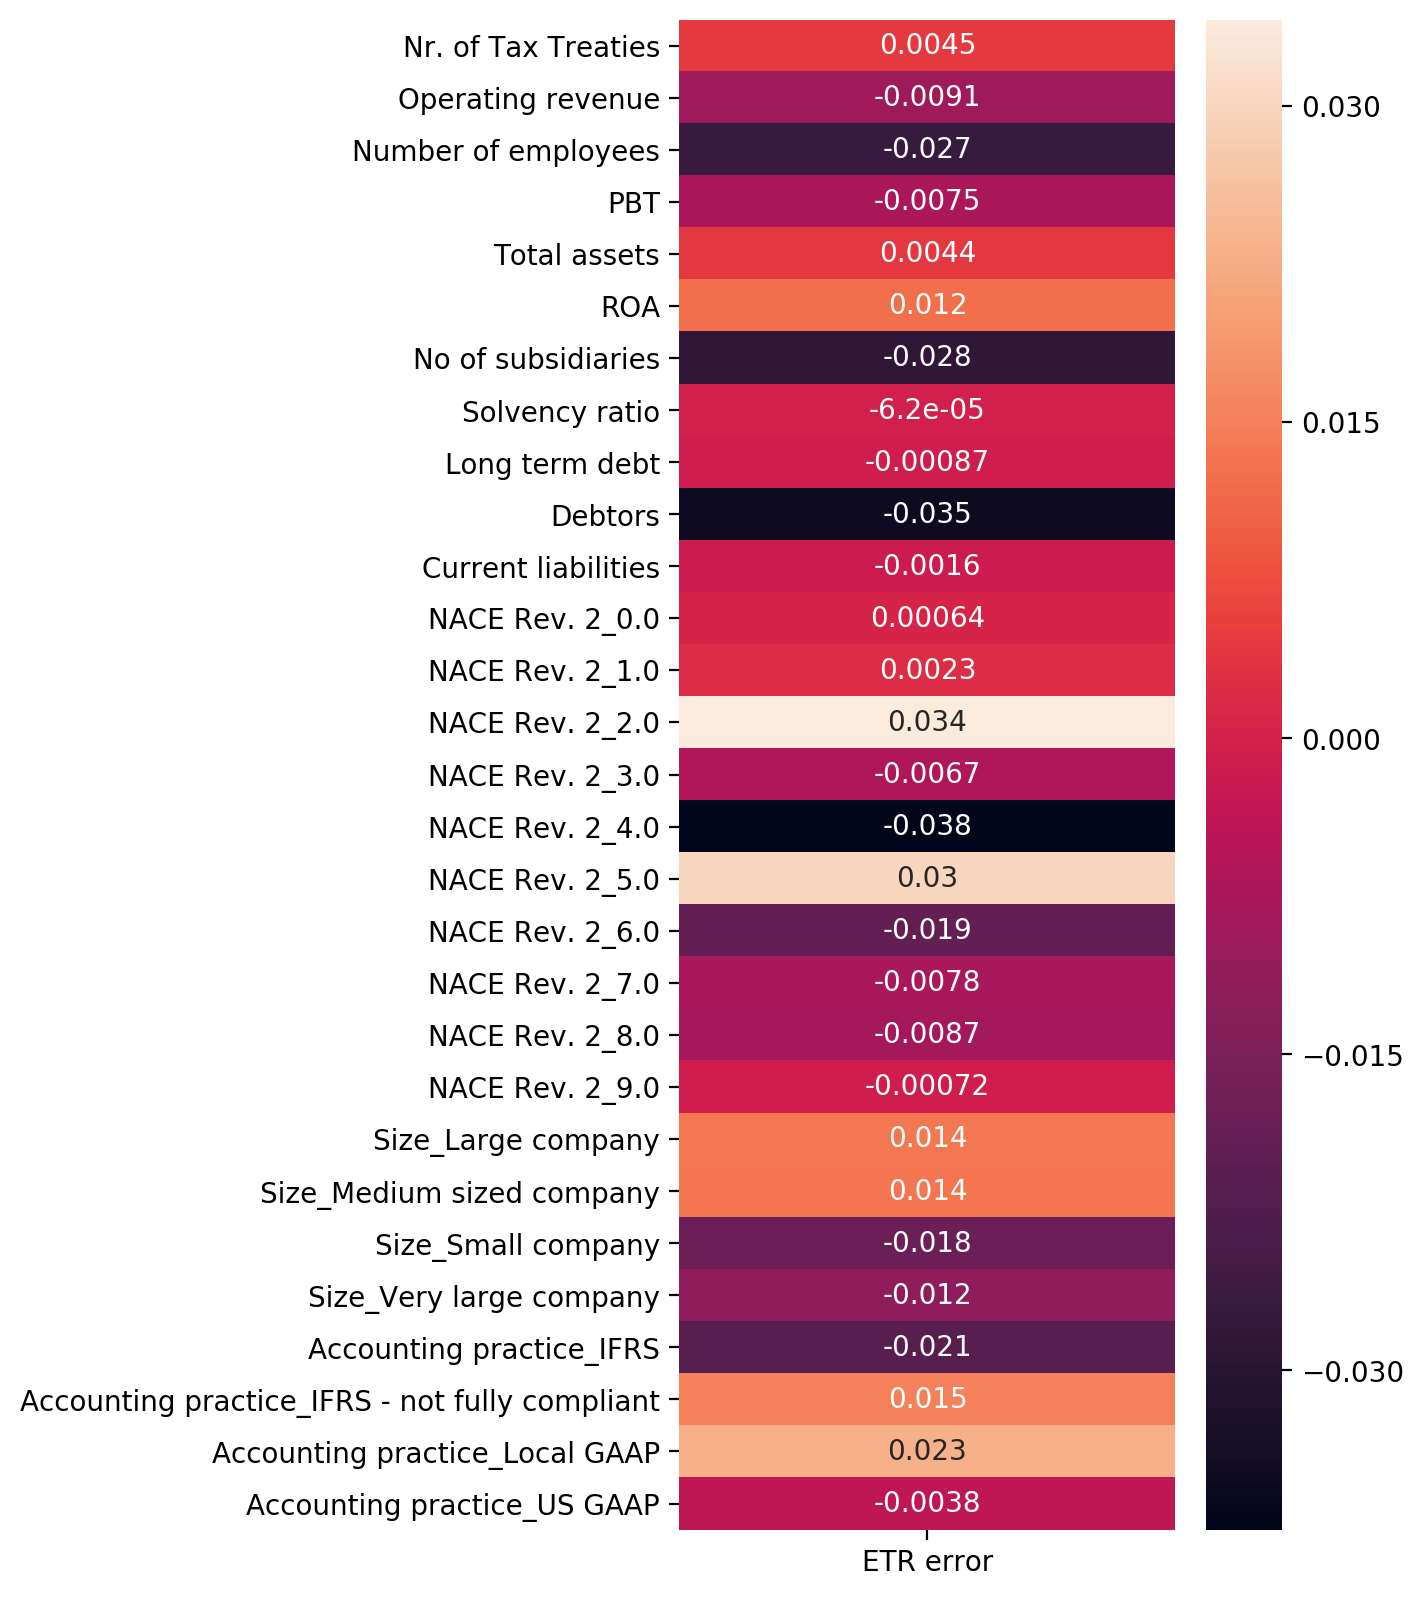

In [34]:
from matplotlib.pyplot import figure
y_error = pd.DataFrame(data = [(y_pred_winsor2-y_test_final_winsor2)]).T
y_error = pd.concat([X_test_final_winsor2, y_error], axis = 1)

cormat = y_error.corr()
round(cormat,3)

ETR_heatmap = cormat['ETR']
ETR_heatmap = pd.DataFrame(ETR_heatmap)
ETR_heatmap.rename(columns = {'ETR':'ETR error'}, inplace = True)
ETR_heatmap = ETR_heatmap.drop('ETR')

figure(figsize=(4, 10), dpi=200)
sns.heatmap(ETR_heatmap, annot = True)

In [35]:
ETR_heatmap.sort_values('ETR error')

,ETR error
NACE Rev. 2_4.0,-0.037547
Debtors,-0.035141
No of subsidiaries,-0.028476
Number of employees,-0.026690
Accounting practice_IFRS,-0.021121
NACE Rev. 2_6.0,-0.019171
Size_Small company,-0.017929
Size_Very large company,-0.011607
Operating revenue,-0.009149
NACE Rev. 2_8.0,-0.008687
